In [3]:
%pip uninstall tensorflow-datasets tensorflow-metadata -y
%pip install tensorflow==2.9
%pip install sciann
%pip install wandb -U

Found existing installation: tensorflow-datasets 4.9.6
Uninstalling tensorflow-datasets-4.9.6:
  Successfully uninstalled tensorflow-datasets-4.9.6
Found existing installation: tensorflow-metadata 1.15.0
Uninstalling tensorflow-metadata-1.15.0:
  Successfully uninstalled tensorflow-metadata-1.15.0


In [ ]:
#Paquetes para modelos
import sciann as sn
from sciann.utils import math as scmath
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import wandb
import pprint

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.9.0 
Python Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] 



In [ ]:
from google.colab import drive
!{google.colab.executable} -m pip install google.colab
drive.mount('/content/drive')

/bin/bash: line 1: {google.colab.executable}: command not found
Mounted at /content/drive


#Desglose del experimento

En este experimento se va a trabajar con:

- Un conjunto de datos reducido (X_train_reduced_u_list, X_test_reduced_u_list) para que los datos respeten dimensiones cuadradas atendiendo.
- Un conjunto de datos ampliado (X_train_reduced_u_list, X_test_reduced_u_list) que respete las dimensiones cuadradas aprovechando todos los datos de entrenamiento proporcionados.

Se realizarán por tanto dos tareas de entrenamiento por separado, una para cada configuración de datos.

In [ ]:
#Estamos trabajando con datos que han sido previamente serializados .
#La serialización es el proceso de convertir un objeto en una secuencia de bytes,
#que luego puede ser almacenada en un archivo.

d_train = np.load('drive/MyDrive/antiderivative_aligned_train.npz', allow_pickle=True)
d_test = np.load('drive/MyDrive/antiderivative_aligned_test.npz', allow_pickle=True)

#Caso 1: Aproximación de operador con conjunto de datos reducido

##Procesamiento de datos

In [ ]:
#X_train[0] : Matriz nxm que describe las localizaciones u(x1),..., u(xm) en n funciones u distintas.
#X_train[1] : Localizaciones x1,...,xm de los sensores.
#y_train : Matriz nxm que describe la salida esperada G(uj)(xi), para cada j=1,..,n, i=1,...m.

X_train = (d_train["X"][0].astype(np.float32), d_train["X"][1].astype(np.float32))
y_train = d_train["y"].astype(np.float32)

In [ ]:
X_test = (d_test["X"][0].astype(np.float32), d_test["X"][1].astype(np.float32))
y_test = d_test["y"].astype(np.float32)

In [ ]:
n = y_train.shape[0]
m = y_train.shape[1]

In [ ]:
print("Dimensiones nxm: ",y_train.shape)

Dimensiones nxm:  (150, 100)


In [ ]:
X_train_reduc_u_list = [X_train[0][:m,i].flatten()[:None] for i in range(m)]
X_test_reduc_u_list = [X_test[0][:m,i].flatten()[:None] for i in range(m)]

##Definición del entorno de experimentación y del modelo

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'val_loss',
    'goal': 'minimize'
    }

sweep_config['metric'] = metric

In [ ]:
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'adadelta','nadam']
        },
    'activation': {
        'values': ['sigmoid','tanh','elu']
        },
    'n_in_layer': {
        'values': [20,40,80]
    },
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0.001,
        'max': 0.1
      },
    'epochs': {
        'value': 5000
    },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 32,
        'max': 80,
      }
    }

sweep_config['parameters'] = parameters_dict
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'val_loss'},
 'parameters': {'activation': {'values': ['sigmoid', 'tanh', 'elu']},
                'batch_size': {'distribution': 'q_log_uniform_values',
                               'max': 80,
                               'min': 32,
                               'q': 8},
                'epochs': {'value': 5000},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0.001},
                'n_in_layer': {'values': [20, 40, 80]},
                'optimizer': {'values': ['adam', 'adadelta', 'nadam']}}}


In [ ]:
def sweep_train_m_100(config_defaults=None):
    with wandb.init(config=config_defaults,project="experimento-3-b-m100"):

        x = sn.Variable("x")
        ux = [sn.Variable(f'ux{i}') for i in range(m)]


        #Definición de subredes

        subnet_branches = [sn.Functional(f'branch_out_{i}', ux, [1], activation=wandb.config.activation) for i in range(wandb.config.n_in_layer)]
        subnet_trunk = sn.Functional("trunk_out",x ,[wandb.config.n_in_layer], wandb.config.activation)

        #Construcción manual del producto cartesiano de las subredes
        productos = []

        for i in range(wandb.config.n_in_layer):
          productos.append(sn.utils.mul(subnet_branches[i],subnet_trunk))

        s = sn.utils.add(productos[0],productos[1])

        for i in range(2,wandb.config.n_in_layer):
          s = sn.utils.add(s,productos[i])

        #Restricciones del modelo
        d1 = sn.Data(s)

        # Definimos el modelo
        modelo_operador= sn.SciModel(inputs = ux+[x], targets=[d1], loss_func='MSE',optimizer=wandb.config.optimizer)#,plot_to_file="operador_b.png")

        modelo_operador.compile()
        start_time = time.time()
        history = modelo_operador.train(
                           X_train_reduc_u_list+[X_train[1]],y_train,
                           batch_size=wandb.config.batch_size,
                           epochs=wandb.config.epochs,
                           learning_rate=wandb.config.learning_rate,
                            callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", min_delta = 0, patience=10,verbose=1)],#,WandbCallback()],
                            validation_data=(X_test_reduc_u_list + [X_test[1]], y_test))
        wandb.log(
    {
        "val_loss": min(history.history['val_loss']),
        'loss': min(history.history['loss']),
        'time': time.time() - start_time
    })
    wandb.finish()

In [ ]:
sweep_id_val_m_100 = wandb.sweep(sweep_config, project="experimento-3-b-m100")

Create sweep with ID: qgvxb8dh
Sweep URL: https://wandb.ai/vaatiper-Universidad%20de%20Granada/experimento-3-b-m100/sweeps/qgvxb8dh


In [ ]:
wandb.agent(sweep_id_val_m_100,function=sweep_train_m_100,count=20)

#Caso 2: Aproximación de operador con conjunto de datos ampliado

##Procesamiento de datos

In [ ]:
#Aumento del conjunto de datos
X_train_0_ampliado = np.concatenate([X_train[0][:][:],X_train[0][:,:50]],axis=1)
print(f"Dimensiones de los datos de entrada: {X_train_0_ampliado.shape}")
X_train_1_ampliado = np.concatenate([X_train[1][:],X_train[1][:50]],axis=0)
print(f"Tamaño de la partición: {X_train_1_ampliado.shape}")
y_train_ampliado = np.concatenate([y_train[:][:],y_train[:,:50]],axis=1)
print(f"Dimensiones de la salida: {y_train_ampliado.shape}")

Dimensiones de los datos de entrada: (150, 150)
Tamaño de la partición: (150, 1)
Dimensiones de la salida: (150, 150)


In [ ]:
X_test_0_ampliado = np.concatenate([X_test[0][:][:],X_test[0][:,:50]],axis=1)
print(f"Dimensiones de los datos de entrada: {X_test_0_ampliado.shape}")
X_test_1_ampliado = np.concatenate([X_test[1][:],X_test[1][:50]],axis=0)
print(f"Tamaño de la partición: {X_test_1_ampliado.shape}")
y_test_ampliado = np.concatenate([y_test[:][:],y_test[:,:50]],axis=1)
print(f"Dimensiones de la salida: {y_train_ampliado.shape}")

Dimensiones de los datos de entrada: (1000, 150)
Tamaño de la partición: (150, 1)
Dimensiones de la salida: (150, 150)


In [ ]:
n = y_train_ampliado.shape[0]
m = y_train_ampliado.shape[1]

In [ ]:
X_train_ampl_u_list = [X_train_0_ampliado[:m,i].flatten()[:None] for i in range(m)]
X_test_ampl_u_list = [X_test_0_ampliado[:m,i].flatten()[:None] for i in range(m)]

#Comprobamos que hemos realizado la repartición correcta de los datos
# print(X_train_u_list[0],X_train_[:,0])
# print(X_train_u_list[0],X_train_u_list[100])

##Definición del entorno de experimentación y del modelo

In [ ]:
def sweep_train_m_150(config_defaults=None):
    with wandb.init(config=config_defaults):

        x = sn.Variable("x")
        ux = [sn.Variable(f'ux{i}') for i in range(m)]


        #Definición de subredes

        subnet_branches = [sn.Functional(f'branch_out_{i}', ux, [1], activation=wandb.config.activation) for i in range(wandb.config.n_in_layer)]
        subnet_trunk = sn.Functional("trunk_out",x ,[wandb.config.n_in_layer], wandb.config.activation)

        #Construcción manual del producto cartesiano de las subredes
        productos = []

        for i in range(wandb.config.n_in_layer):
          productos.append(sn.utils.mul(subnet_branches[i],subnet_trunk))

        s = sn.utils.add(productos[0],productos[1])

        for i in range(2,wandb.config.n_in_layer):
          s = sn.utils.add(s,productos[i])

        #Restricciones del modelo
        d1 = sn.Data(s)

        # Definimos el modelo
        modelo_operador= sn.SciModel(inputs = ux+[x], targets=[d1], loss_func='MSE',optimizer=wandb.config.optimizer)

        modelo_operador.compile()
        start_time = time.time()
        history = modelo_operador.train(
                           X_train_ampl_u_list+[X_train_1_ampliado],y_train_ampliado,
                           batch_size=wandb.config.batch_size,
                           epochs=wandb.config.epochs,
                           learning_rate=wandb.config.learning_rate,
                           callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", min_delta = 0, patience=10,verbose=1)],
                           validation_data=(X_test_ampl_u_list + [X_test_1_ampliado], y_test_ampliado))
        wandb.log(
                          {
                              "val_loss": min(history.history['val_loss']),
                              'loss': min(history.history['loss']),
                              'time': time.time() - start_time
                          })
        wandb.finish()

In [ ]:
sweep_id_val_m_150 = wandb.sweep(sweep_config, project="experimento-3-b-m150")

Create sweep with ID: h8dcswmo
Sweep URL: https://wandb.ai/vaatiper-Universidad%20de%20Granada/experimento-3-b-m150/sweeps/h8dcswmo


In [ ]:
wandb.agent(sweep_id_val_m_150,function=sweep_train_m_150,count=20)

wandb: Agent Starting Run: v16k6o5r with config:
wandb: 	activation: elu
wandb: 	batch_size: 40
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.02744286520389004
wandb: 	n_in_layer: 40
wandb: 	optimizer: nadam



Total samples: 150 
Batch size: 40 
Total batches: 4 

Epoch 1/5000
1/4 [======>.......................] - ETA: 26s - batch: 0.0000e+00 - size: 40.0000 - loss: 0.5134

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


4/4 [==============================] - 10s 243ms/step - batch: 1.5000 - size: 37.5000 - loss: 395.0878 - val_loss: 9.2180 - lr: 0.0274 - time: 9.6704
Epoch 2/5000
4/4 [==============================] - 9s 311ms/step - batch: 1.5000 - size: 37.5000 - loss: 8.5990 - val_loss: 0.9116 - lr: 0.0274 - time: 8.5589
Epoch 3/5000
4/4 [==============================] - 9s 473ms/step - batch: 1.5000 - size: 37.5000 - loss: 1.5617 - val_loss: 13.9122 - lr: 0.0274 - time: 9.4626
Epoch 4/5000
4/4 [==============================] - 10s 561ms/step - batch: 1.5000 - size: 37.5000 - loss: 34.7302 - val_loss: 21.9804 - lr: 0.0274 - time: 10.3175
Epoch 5/5000
4/4 [==============================] - 11s 594ms/step - batch: 1.5000 - size: 37.5000 - loss: 7.4688 - val_loss: 8.0975 - lr: 0.0274 - time: 10.8340
Epoch 6/5000
4/4 [==============================] - 12s 788ms/step - batch: 1.5000 - size: 37.5000 - loss: 1.2773 - val_loss: 0.4869 - lr: 0.0274 - time: 12.0657
Epoch 7/5000
4/4 [=======================

loss,▁
time,▁
val_loss,▁
loss,0.00856
time,518.08274
val_loss,0.3423


wandb: Agent Starting Run: s6bb2639 with config:
wandb: 	activation: elu
wandb: 	batch_size: 48
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.01845015647133132
wandb: 	n_in_layer: 20
wandb: 	optimizer: adam



Total samples: 150 
Batch size: 48 
Total batches: 4 

Epoch 1/5000
4/4 [==============================] - 3s 118ms/step - batch: 1.5000 - size: 37.5000 - loss: 26.2207 - val_loss: 4.6074 - lr: 0.0185 - time: 2.5176
Epoch 2/5000
4/4 [==============================] - 2s 121ms/step - batch: 1.5000 - size: 37.5000 - loss: 18.9816 - val_loss: 10.9964 - lr: 0.0185 - time: 1.6647
Epoch 3/5000
4/4 [==============================] - 2s 175ms/step - batch: 1.5000 - size: 37.5000 - loss: 6.7017 - val_loss: 3.8453 - lr: 0.0185 - time: 1.8746
Epoch 4/5000
4/4 [==============================] - 2s 141ms/step - batch: 1.5000 - size: 37.5000 - loss: 1.2422 - val_loss: 2.1824 - lr: 0.0185 - time: 1.8534
Epoch 5/5000
4/4 [==============================] - 2s 201ms/step - batch: 1.5000 - size: 37.5000 - loss: 0.9277 - val_loss: 2.2080 - lr: 0.0185 - time: 2.1211
Epoch 6/5000
4/4 [==============================] - 2s 216ms/step - batch: 1.5000 - size: 37.5000 - loss: 1.0178 - val_loss: 0.9302 - lr: 0.0

loss,▁
time,▁
val_loss,▁
loss,0.05181
time,71.10608
val_loss,0.11079


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: urp8i04m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 40
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.027858790649507872
wandb: 	n_in_layer: 20
wandb: 	optimizer: adam



Total samples: 150 
Batch size: 40 
Total batches: 4 

Epoch 1/5000
4/4 [==============================] - 3s 123ms/step - batch: 1.5000 - size: 37.5000 - loss: 1.0401 - val_loss: 1.0706 - lr: 0.0279 - time: 2.5562
Epoch 2/5000
4/4 [==============================] - 2s 123ms/step - batch: 1.5000 - size: 37.5000 - loss: 0.8536 - val_loss: 0.3871 - lr: 0.0279 - time: 1.7229
Epoch 3/5000
4/4 [==============================] - 2s 134ms/step - batch: 1.5000 - size: 37.5000 - loss: 0.2956 - val_loss: 0.2483 - lr: 0.0279 - time: 1.7757
Epoch 4/5000
4/4 [==============================] - 2s 149ms/step - batch: 1.5000 - size: 37.5000 - loss: 0.2733 - val_loss: 0.2283 - lr: 0.0279 - time: 1.8963
Epoch 5/5000
4/4 [==============================] - 3s 182ms/step - batch: 1.5000 - size: 37.5000 - loss: 0.2296 - val_loss: 0.5357 - lr: 0.0279 - time: 2.8925
Epoch 6/5000
4/4 [==============================] - 2s 191ms/step - batch: 1.5000 - size: 37.5000 - loss: 0.1897 - val_loss: 0.4767 - lr: 0.0279

loss,▁
time,▁
val_loss,▁
loss,0.0085
time,35.87818
val_loss,0.22833


wandb: Agent Starting Run: txq5jcrk with config:
wandb: 	activation: elu
wandb: 	batch_size: 72
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.014691117559575173
wandb: 	n_in_layer: 40
wandb: 	optimizer: nadam



Total samples: 150 
Batch size: 72 
Total batches: 3 

Epoch 1/5000
3/3 [==============================] - 9s 350ms/step - batch: 1.0000 - size: 50.0000 - loss: 3.0823 - val_loss: 11.1322 - lr: 0.0147 - time: 9.4024
Epoch 2/5000
3/3 [==============================] - 8s 461ms/step - batch: 1.0000 - size: 50.0000 - loss: 5.4006 - val_loss: 0.4766 - lr: 0.0147 - time: 8.3083
Epoch 3/5000
3/3 [==============================] - 9s 584ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.5813 - val_loss: 0.2257 - lr: 0.0147 - time: 9.4440
Epoch 4/5000
3/3 [==============================] - 11s 839ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.2851 - val_loss: 0.2194 - lr: 0.0147 - time: 10.6583
Epoch 5/5000
3/3 [==============================] - 11s 957ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.2106 - val_loss: 0.2577 - lr: 0.0147 - time: 11.2007
Epoch 6/5000
3/3 [==============================] - 12s 1s/step - batch: 1.0000 - size: 50.0000 - loss: 0.2301 - val_loss: 0.4389 - lr: 0.0

loss,▁
time,▁
val_loss,▁
loss,0.17063
time,185.52482
val_loss,0.2194


wandb: Agent Starting Run: d40xotl5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.011506277524627122
wandb: 	n_in_layer: 40
wandb: 	optimizer: nadam



Total samples: 150 
Batch size: 64 
Total batches: 3 

Epoch 1/5000
3/3 [==============================] - 9s 379ms/step - batch: 1.0000 - size: 50.0000 - loss: 3.5038 - val_loss: 0.2392 - lr: 0.0115 - time: 9.4535
Epoch 2/5000
3/3 [==============================] - 8s 489ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.2364 - val_loss: 0.5039 - lr: 0.0115 - time: 8.4799
Epoch 3/5000
3/3 [==============================] - 12s 2s/step - batch: 1.0000 - size: 50.0000 - loss: 0.1243 - val_loss: 0.7841 - lr: 0.0115 - time: 11.6264
Epoch 4/5000
3/3 [==============================] - 11s 777ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.2668 - val_loss: 0.3199 - lr: 0.0115 - time: 10.6362
Epoch 5/5000
3/3 [==============================] - 12s 928ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.0445 - val_loss: 0.4468 - lr: 0.0115 - time: 11.8790
Epoch 6/5000
3/3 [==============================] - 12s 1s/step - batch: 1.0000 - size: 50.0000 - loss: 0.0743 - val_loss: 0.5141 - lr: 0.011

loss,▁
time,▁
val_loss,▁
loss,0.00859
time,140.14591
val_loss,0.23923


wandb: Agent Starting Run: fglds5nj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 40
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.0524172286306633
wandb: 	n_in_layer: 40
wandb: 	optimizer: adam



Total samples: 150 
Batch size: 40 
Total batches: 4 

Epoch 1/5000
4/4 [==============================] - 5s 193ms/step - batch: 1.5000 - size: 37.5000 - loss: 335.4182 - val_loss: 57.7076 - lr: 0.0524 - time: 4.7717
Epoch 2/5000
4/4 [==============================] - 3s 202ms/step - batch: 1.5000 - size: 37.5000 - loss: 30.3611 - val_loss: 25.3030 - lr: 0.0524 - time: 3.0676
Epoch 3/5000
4/4 [==============================] - 5s 245ms/step - batch: 1.5000 - size: 37.5000 - loss: 24.9351 - val_loss: 29.7424 - lr: 0.0524 - time: 5.2282
Epoch 4/5000
4/4 [==============================] - 4s 263ms/step - batch: 1.5000 - size: 37.5000 - loss: 28.7454 - val_loss: 32.7999 - lr: 0.0524 - time: 3.6831
Epoch 5/5000
4/4 [==============================] - 4s 296ms/step - batch: 1.5000 - size: 37.5000 - loss: 27.0973 - val_loss: 24.0900 - lr: 0.0524 - time: 3.9443
Epoch 6/5000
4/4 [==============================] - 4s 326ms/step - batch: 1.5000 - size: 37.5000 - loss: 31.6934 - val_loss: 34.4962

loss,▁
time,▁
val_loss,▁
loss,0.06927
time,233.77269
val_loss,1.01415


wandb: Agent Starting Run: 8xvll318 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.05841440396848427
wandb: 	n_in_layer: 40
wandb: 	optimizer: adadelta



Total samples: 150 
Batch size: 64 
Total batches: 3 

Epoch 1/5000
3/3 [==============================] - 7s 311ms/step - batch: 1.0000 - size: 50.0000 - loss: 1.0510 - val_loss: 1.0081 - lr: 0.0584 - time: 6.7083
Epoch 2/5000
3/3 [==============================] - 3s 311ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.7503 - val_loss: 0.8693 - lr: 0.0584 - time: 3.1637
Epoch 3/5000
3/3 [==============================] - 3s 346ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.6242 - val_loss: 0.7637 - lr: 0.0584 - time: 3.3952
Epoch 4/5000
3/3 [==============================] - 4s 385ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.5974 - val_loss: 0.6863 - lr: 0.0584 - time: 3.6563
Epoch 5/5000
3/3 [==============================] - 4s 537ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.5419 - val_loss: 0.6131 - lr: 0.0584 - time: 4.0595
Epoch 6/5000
3/3 [==============================] - 4s 458ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.5016 - val_loss: 0.5531 - lr: 0.0584

loss,▁
time,▁
val_loss,▁
loss,0.18
time,283.64015
val_loss,0.27241


wandb: Agent Starting Run: kmw0qybg with config:
wandb: 	activation: elu
wandb: 	batch_size: 64
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.09295342533732838
wandb: 	n_in_layer: 40
wandb: 	optimizer: adadelta



Total samples: 150 
Batch size: 64 
Total batches: 3 

Epoch 1/5000
3/3 [==============================] - 5s 278ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.8524 - val_loss: 0.6519 - lr: 0.0930 - time: 4.5591
Epoch 2/5000
3/3 [==============================] - 3s 298ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.5042 - val_loss: 0.4986 - lr: 0.0930 - time: 3.0305
Epoch 3/5000
3/3 [==============================] - 3s 325ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.3425 - val_loss: 0.4463 - lr: 0.0930 - time: 3.2450
Epoch 4/5000
3/3 [==============================] - 3s 374ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.2748 - val_loss: 0.4520 - lr: 0.0930 - time: 3.4602
Epoch 5/5000
3/3 [==============================] - 6s 425ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.2862 - val_loss: 0.4118 - lr: 0.0930 - time: 5.6477
Epoch 6/5000
3/3 [==============================] - 4s 457ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.2552 - val_loss: 0.3932 - lr: 0.0930

loss,▁
time,▁
val_loss,▁
loss,0.05859
time,237.25317
val_loss,0.33323


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4xe0gtyu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.021345558829581175
wandb: 	n_in_layer: 20
wandb: 	optimizer: adadelta



Total samples: 150 
Batch size: 32 
Total batches: 5 

Epoch 1/5000
5/5 [==============================] - 2s 90ms/step - batch: 2.0000 - size: 30.0000 - loss: 0.2543 - val_loss: 0.2005 - lr: 0.0213 - time: 2.4738
Epoch 2/5000
5/5 [==============================] - 2s 91ms/step - batch: 2.0000 - size: 30.0000 - loss: 0.2515 - val_loss: 0.2021 - lr: 0.0213 - time: 1.6227
Epoch 3/5000
5/5 [==============================] - 2s 108ms/step - batch: 2.0000 - size: 30.0000 - loss: 0.2534 - val_loss: 0.2029 - lr: 0.0213 - time: 1.7720
Epoch 4/5000
5/5 [==============================] - 2s 117ms/step - batch: 2.0000 - size: 30.0000 - loss: 0.2587 - val_loss: 0.2045 - lr: 0.0213 - time: 1.9598
Epoch 5/5000
5/5 [==============================] - 2s 123ms/step - batch: 2.0000 - size: 30.0000 - loss: 0.2505 - val_loss: 0.2069 - lr: 0.0213 - time: 1.9885
Epoch 6/5000
5/5 [==============================] - 2s 135ms/step - batch: 2.0000 - size: 30.0000 - loss: 0.2532 - val_loss: 0.2081 - lr: 0.0213 -

loss,▁
time,▁
val_loss,▁
loss,0.24936
time,26.85522
val_loss,0.20051


wandb: Agent Starting Run: e1fw45kx with config:
wandb: 	activation: elu
wandb: 	batch_size: 48
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.04951675349230309
wandb: 	n_in_layer: 80
wandb: 	optimizer: adam



Total samples: 150 
Batch size: 48 
Total batches: 4 

Epoch 1/5000
4/4 [==============================] - 10s 372ms/step - batch: 1.5000 - size: 37.5000 - loss: 28820.6892 - val_loss: 60693.0938 - lr: 0.0495 - time: 10.2099
Epoch 2/5000
4/4 [==============================] - 6s 389ms/step - batch: 1.5000 - size: 37.5000 - loss: 17443.6109 - val_loss: 7177.1534 - lr: 0.0495 - time: 6.2651
Epoch 3/5000
4/4 [==============================] - 7s 430ms/step - batch: 1.5000 - size: 37.5000 - loss: 6127.2844 - val_loss: 21266.9507 - lr: 0.0495 - time: 6.8459
Epoch 4/5000
4/4 [==============================] - 8s 492ms/step - batch: 1.5000 - size: 37.5000 - loss: 6635.8806 - val_loss: 4338.8380 - lr: 0.0495 - time: 7.6826
Epoch 5/5000
4/4 [==============================] - 8s 663ms/step - batch: 1.5000 - size: 37.5000 - loss: 5084.2017 - val_loss: 694.8592 - lr: 0.0495 - time: 8.2824
Epoch 6/5000
4/4 [==============================] - 8s 612ms/step - batch: 1.5000 - size: 37.5000 - loss: 196

loss,▁
time,▁
val_loss,▁
loss,0.20184
time,1029.71977
val_loss,0.25057


wandb: Agent Starting Run: paeugi8h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.04442454035511177
wandb: 	n_in_layer: 80
wandb: 	optimizer: adadelta



Total samples: 150 
Batch size: 32 
Total batches: 5 

Epoch 1/5000
5/5 [==============================] - 10s 313ms/step - batch: 2.0000 - size: 30.0000 - loss: 124.1995 - val_loss: 130.5767 - lr: 0.0444 - time: 10.0430
Epoch 2/5000
5/5 [==============================] - 7s 377ms/step - batch: 2.0000 - size: 30.0000 - loss: 100.1612 - val_loss: 104.5447 - lr: 0.0444 - time: 6.6543
Epoch 3/5000
5/5 [==============================] - 7s 353ms/step - batch: 2.0000 - size: 30.0000 - loss: 80.6660 - val_loss: 84.2732 - lr: 0.0444 - time: 7.1302
Epoch 4/5000
5/5 [==============================] - 8s 482ms/step - batch: 2.0000 - size: 30.0000 - loss: 65.9162 - val_loss: 68.8363 - lr: 0.0444 - time: 7.8592
Epoch 5/5000
5/5 [==============================] - 8s 431ms/step - batch: 2.0000 - size: 30.0000 - loss: 54.1041 - val_loss: 55.8354 - lr: 0.0444 - time: 8.1841
Epoch 6/5000
5/5 [==============================] - 9s 491ms/step - batch: 2.0000 - size: 30.0000 - loss: 45.7548 - val_loss: 45

loss,▁
time,▁
val_loss,▁
loss,0.06931
time,2641.36754
val_loss,0.43702


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z5oe9ju7 with config:
wandb: 	activation: elu
wandb: 	batch_size: 72
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.04701276838800212
wandb: 	n_in_layer: 80
wandb: 	optimizer: adadelta



Total samples: 150 
Batch size: 72 
Total batches: 3 

Epoch 1/5000
3/3 [==============================] - 18s 555ms/step - batch: 1.0000 - size: 50.0000 - loss: 9.2693 - val_loss: 10.1792 - lr: 0.0470 - time: 18.3989
Epoch 2/5000
3/3 [==============================] - 6s 607ms/step - batch: 1.0000 - size: 50.0000 - loss: 12.6280 - val_loss: 6.8317 - lr: 0.0470 - time: 6.3636
Epoch 3/5000
3/3 [==============================] - 7s 656ms/step - batch: 1.0000 - size: 50.0000 - loss: 4.8664 - val_loss: 5.8294 - lr: 0.0470 - time: 7.3012
Epoch 4/5000
3/3 [==============================] - 8s 759ms/step - batch: 1.0000 - size: 50.0000 - loss: 4.0288 - val_loss: 5.1958 - lr: 0.0470 - time: 7.5754
Epoch 5/5000
3/3 [==============================] - 9s 931ms/step - batch: 1.0000 - size: 50.0000 - loss: 3.4092 - val_loss: 6.0379 - lr: 0.0470 - time: 8.5369
Epoch 6/5000
3/3 [==============================] - 9s 1s/step - batch: 1.0000 - size: 50.0000 - loss: 3.3917 - val_loss: 5.6293 - lr: 0.047

loss,▁
time,▁
val_loss,▁
loss,0.169
time,1052.44812
val_loss,0.57524


wandb: Agent Starting Run: 0ebcw41v with config:
wandb: 	activation: elu
wandb: 	batch_size: 72
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.0810745328585336
wandb: 	n_in_layer: 20
wandb: 	optimizer: adadelta



Total samples: 150 
Batch size: 72 
Total batches: 3 

Epoch 1/5000
3/3 [==============================] - 2s 170ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.1815 - val_loss: 0.2877 - lr: 0.0811 - time: 2.4914
Epoch 2/5000
3/3 [==============================] - 2s 179ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.1344 - val_loss: 0.2626 - lr: 0.0811 - time: 1.6618
Epoch 3/5000
3/3 [==============================] - 2s 198ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.1353 - val_loss: 0.2510 - lr: 0.0811 - time: 1.8066
Epoch 4/5000
3/3 [==============================] - 2s 212ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.1348 - val_loss: 0.2396 - lr: 0.0811 - time: 1.8651
Epoch 5/5000
3/3 [==============================] - 2s 240ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.1267 - val_loss: 0.2558 - lr: 0.0811 - time: 2.0240
Epoch 6/5000
3/3 [==============================] - 2s 326ms/step - batch: 1.0000 - size: 50.0000 - loss: 0.1242 - val_loss: 0.2973 - lr: 0.0811

loss,▁
time,▁
val_loss,▁
loss,0.11047
time,40.3624
val_loss,0.23964


wandb: Agent Starting Run: n984qumd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 40
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.005058380646113727
wandb: 	n_in_layer: 40
wandb: 	optimizer: nadam



Total samples: 150 
Batch size: 40 
Total batches: 4 

Epoch 1/5000
4/4 [==============================] - 9s 253ms/step - batch: 1.5000 - size: 37.5000 - loss: 2.0708 - val_loss: 0.3548 - lr: 0.0051 - time: 9.4063
Epoch 2/5000
4/4 [==============================] - 9s 318ms/step - batch: 1.5000 - size: 37.5000 - loss: 0.2113 - val_loss: 0.2599 - lr: 0.0051 - time: 8.7196
Epoch 3/5000
4/4 [==============================] - 10s 404ms/step - batch: 1.5000 - size: 37.5000 - loss: 0.1607 - val_loss: 0.2697 - lr: 0.0051 - time: 9.7653
Epoch 4/5000
4/4 [==============================] - 10s 514ms/step - batch: 1.5000 - size: 37.5000 - loss: 0.1473 - val_loss: 0.2537 - lr: 0.0051 - time: 10.0796
Epoch 5/5000
4/4 [==============================] - 11s 595ms/step - batch: 1.5000 - size: 37.5000 - loss: 0.1092 - val_loss: 0.2779 - lr: 0.0051 - time: 11.2975
Epoch 6/5000
4/4 [==============================] - 12s 696ms/step - batch: 1.5000 - size: 37.5000 - loss: 0.0672 - val_loss: 0.3296 - lr: 

loss,▁
time,▁
val_loss,▁
loss,0.00841
time,187.85614
val_loss,0.25368


wandb: Agent Starting Run: neeunuyx with config:
wandb: 	activation: elu
wandb: 	batch_size: 56
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.07179916478928128
wandb: 	n_in_layer: 20
wandb: 	optimizer: nadam



Total samples: 150 
Batch size: 56 
Total batches: 3 

Epoch 1/5000
3/3 [==============================] - 5s 218ms/step - batch: 1.0000 - size: 50.0000 - loss: 1861.2368 - val_loss: 3.2721 - lr: 0.0718 - time: 4.8995
Epoch 2/5000
3/3 [==============================] - 4s 269ms/step - batch: 1.0000 - size: 50.0000 - loss: 14.5882 - val_loss: 41.6752 - lr: 0.0718 - time: 4.3516
Epoch 3/5000
3/3 [==============================] - 5s 323ms/step - batch: 1.0000 - size: 50.0000 - loss: 22.6466 - val_loss: 1.8300 - lr: 0.0718 - time: 4.9787
Epoch 4/5000
3/3 [==============================] - 5s 390ms/step - batch: 1.0000 - size: 50.0000 - loss: 5.2681 - val_loss: 6.1521 - lr: 0.0718 - time: 5.0918
Epoch 5/5000
3/3 [==============================] - 6s 605ms/step - batch: 1.0000 - size: 50.0000 - loss: 6.5092 - val_loss: 9.5470 - lr: 0.0718 - time: 5.7979
Epoch 6/5000
3/3 [==============================] - 6s 521ms/step - batch: 1.0000 - size: 50.0000 - loss: 39.4930 - val_loss: 431.1303 - l

loss,▁
time,▁
val_loss,▁
loss,0.17317
time,325.82298
val_loss,0.28252


wandb: Agent Starting Run: 0qbf3pjw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 48
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.01990327236895494
wandb: 	n_in_layer: 20
wandb: 	optimizer: adadelta



Total samples: 150 
Batch size: 48 
Total batches: 4 

Epoch 1/5000
4/4 [==============================] - 2s 115ms/step - batch: 1.5000 - size: 37.5000 - loss: 0.7970 - val_loss: 0.2911 - lr: 0.0199 - time: 2.4542
Epoch 2/5000
4/4 [==============================] - 2s 162ms/step - batch: 1.5000 - size: 37.5000 - loss: 0.6252 - val_loss: 0.3032 - lr: 0.0199 - time: 1.7366
Epoch 3/5000
4/4 [==============================] - 2s 138ms/step - batch: 1.5000 - size: 37.5000 - loss: 0.6794 - val_loss: 0.2746 - lr: 0.0199 - time: 1.7878
Epoch 4/5000
4/4 [==============================] - 2s 145ms/step - batch: 1.5000 - size: 37.5000 - loss: 0.5943 - val_loss: 0.2731 - lr: 0.0199 - time: 1.9204
Epoch 5/5000
4/4 [==============================] - 2s 162ms/step - batch: 1.5000 - size: 37.5000 - loss: 0.4975 - val_loss: 0.2681 - lr: 0.0199 - time: 2.0302
Epoch 6/5000
4/4 [==============================] - 2s 176ms/step - batch: 1.5000 - size: 37.5000 - loss: 0.4735 - val_loss: 0.2662 - lr: 0.0199

loss,▁
time,▁
val_loss,▁
loss,0.37246
time,56.76336
val_loss,0.25971


wandb: Agent Starting Run: xoqwsw7h with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 48
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.00683098515609665
wandb: 	n_in_layer: 40
wandb: 	optimizer: adadelta



Total samples: 150 
Batch size: 48 
Total batches: 4 

Epoch 1/5000
4/4 [==============================] - 5s 199ms/step - batch: 1.5000 - size: 37.5000 - loss: 2.7817 - val_loss: 2.0244 - lr: 0.0068 - time: 4.7062
Epoch 2/5000
4/4 [==============================] - 3s 223ms/step - batch: 1.5000 - size: 37.5000 - loss: 2.1748 - val_loss: 1.9603 - lr: 0.0068 - time: 3.2107
Epoch 3/5000
4/4 [==============================] - 4s 233ms/step - batch: 1.5000 - size: 37.5000 - loss: 2.0827 - val_loss: 1.8974 - lr: 0.0068 - time: 3.5525
Epoch 4/5000
4/4 [==============================] - 4s 406ms/step - batch: 1.5000 - size: 37.5000 - loss: 2.1851 - val_loss: 1.9070 - lr: 0.0068 - time: 4.1050
Epoch 5/5000
4/4 [==============================] - 4s 284ms/step - batch: 1.5000 - size: 37.5000 - loss: 2.3977 - val_loss: 1.7591 - lr: 0.0068 - time: 3.8438
Epoch 6/5000
4/4 [==============================] - 4s 380ms/step - batch: 1.5000 - size: 37.5000 - loss: 2.6159 - val_loss: 1.7538 - lr: 0.0068

loss,▁
time,▁
val_loss,▁
loss,0.17609
time,1230.09746
val_loss,0.37909


wandb: Agent Starting Run: ujhx44vc with config:
wandb: 	activation: elu
wandb: 	batch_size: 32
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.05270091998864329
wandb: 	n_in_layer: 20
wandb: 	optimizer: adadelta



Total samples: 150 
Batch size: 32 
Total batches: 5 

Epoch 1/5000
5/5 [==============================] - 3s 94ms/step - batch: 2.0000 - size: 30.0000 - loss: 3.2942 - val_loss: 4.7512 - lr: 0.0527 - time: 2.5338
Epoch 2/5000
5/5 [==============================] - 2s 95ms/step - batch: 2.0000 - size: 30.0000 - loss: 2.7936 - val_loss: 4.1100 - lr: 0.0527 - time: 1.6418
Epoch 3/5000
5/5 [==============================] - 2s 102ms/step - batch: 2.0000 - size: 30.0000 - loss: 2.5828 - val_loss: 3.5860 - lr: 0.0527 - time: 1.7379
Epoch 4/5000
5/5 [==============================] - 2s 113ms/step - batch: 2.0000 - size: 30.0000 - loss: 2.2055 - val_loss: 3.1448 - lr: 0.0527 - time: 1.8693
Epoch 5/5000
5/5 [==============================] - 2s 129ms/step - batch: 2.0000 - size: 30.0000 - loss: 2.0065 - val_loss: 2.8733 - lr: 0.0527 - time: 2.0172
Epoch 6/5000
5/5 [==============================] - 2s 135ms/step - batch: 2.0000 - size: 30.0000 - loss: 1.8118 - val_loss: 2.4825 - lr: 0.0527 -

loss,▁
time,▁
val_loss,▁
loss,0.06728
time,293.31454
val_loss,0.32432


wandb: Agent Starting Run: vrobl8ju with config:
wandb: 	activation: elu
wandb: 	batch_size: 80
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.022479207495646768
wandb: 	n_in_layer: 80
wandb: 	optimizer: nadam



Total samples: 150 
Batch size: 80 
Total batches: 2 

Epoch 1/5000
2/2 [==============================] - 22s 2s/step - batch: 0.5000 - size: 75.0000 - loss: 387.8790 - val_loss: 776.7551 - lr: 0.0225 - time: 21.8342
Epoch 2/5000
2/2 [==============================] - 19s 2s/step - batch: 0.5000 - size: 75.0000 - loss: 429.1930 - val_loss: 15.7943 - lr: 0.0225 - time: 18.5483
Epoch 3/5000
2/2 [==============================] - 20s 3s/step - batch: 0.5000 - size: 75.0000 - loss: 8.7364 - val_loss: 6.5688 - lr: 0.0225 - time: 20.3669
Epoch 4/5000
2/2 [==============================] - 22s 3s/step - batch: 0.5000 - size: 75.0000 - loss: 4.8027 - val_loss: 4.1513 - lr: 0.0225 - time: 21.9931
Epoch 5/5000
2/2 [==============================] - 24s 4s/step - batch: 0.5000 - size: 75.0000 - loss: 3.1473 - val_loss: 3.4904 - lr: 0.0225 - time: 23.6998
Epoch 6/5000
2/2 [==============================] - 26s 5s/step - batch: 0.5000 - size: 75.0000 - loss: 2.1627 - val_loss: 1.7833 - lr: 0.0225

loss,▁
time,▁
val_loss,▁
loss,0.36127
time,704.4582
val_loss,0.38628


wandb: Agent Starting Run: 7adtvnr0 with config:
wandb: 	activation: elu
wandb: 	batch_size: 64
wandb: 	epochs: 5000
wandb: 	learning_rate: 0.05921596694753552
wandb: 	n_in_layer: 20
wandb: 	optimizer: adam



Total samples: 150 
Batch size: 64 
Total batches: 3 

Epoch 1/5000
3/3 [==============================] - 3s 174ms/step - batch: 1.0000 - size: 50.0000 - loss: 924.1489 - val_loss: 570.0400 - lr: 0.0592 - time: 2.5099
Epoch 2/5000
3/3 [==============================] - 9s 243ms/step - batch: 1.0000 - size: 50.0000 - loss: 396.6998 - val_loss: 8.5991 - lr: 0.0592 - time: 8.8245
Epoch 3/5000
3/3 [==============================] - 2s 228ms/step - batch: 1.0000 - size: 50.0000 - loss: 429.6617 - val_loss: 84.7668 - lr: 0.0592 - time: 1.9575
Epoch 4/5000
3/3 [==============================] - 2s 230ms/step - batch: 1.0000 - size: 50.0000 - loss: 95.0806 - val_loss: 206.6265 - lr: 0.0592 - time: 2.0247
Epoch 5/5000
3/3 [==============================] - 2s 263ms/step - batch: 1.0000 - size: 50.0000 - loss: 127.9018 - val_loss: 30.8716 - lr: 0.0592 - time: 2.1480
Epoch 6/5000
3/3 [==============================] - 2s 283ms/step - batch: 1.0000 - size: 50.0000 - loss: 14.8395 - val_loss: 0.5

loss,▁
time,▁
val_loss,▁
loss,0.24003
time,89.06015
val_loss,0.28165


In [ ]:
wandb.finish()

#Selección de modelos

Se realiza una comparación directa entre los modelos de DeepONet y SciANN, así como de los modelos que mejor resultado han dado en el ajuste de hiperparámetros.

In [ ]:
n = y_train.shape[0]
m = y_train.shape[1]
N=40

In [ ]:
#Definición de las entradas
x = sn.Variable("x")
ux = [sn.Variable(f'ux{i}') for i in range(m)]


#Definición de subredes

subnet_branches = [sn.Functional(f'branch_out_{i}', ux, [1], activation='sigmoid',kernel_initializer='glorot_uniform',bias_initializer='zeros') for i in range(N)]
subnet_trunk = sn.Functional("trunk_out",x ,[N], 'sigmoid',kernel_initializer='glorot_uniform',bias_initializer='zeros')

#Construcción manual del producto cartesiano de las subredes
productos = []

for i in range(N):
  productos.append(sn.utils.mul(subnet_branches[i],subnet_trunk))

s = sn.utils.add(productos[0],productos[1])

for i in range(2,N):
  s = sn.utils.add(s,productos[i])

#Restricciones del modelo
d1 = sn.Data(s)

# Definimos el modelo
modelo_operador= sn.SciModel(inputs = ux+[x], targets=[d1], loss_func='MSE',optimizer="adam")

# Resumen del modelo
#modelo_operador.summary()

In [ ]:
start_time = time.time()
operador_reduc_val_history = modelo_operador.train(
                           X_train_reduc_u_list+[X_train[1]],y_train,
                           batch_size=100,
                           epochs=3000,
                           learning_rate=0.01,
                           callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", min_delta = 0, patience=20,verbose=1)],
                           validation_data=(X_test_reduc_u_list + [X_test[1]], y_test))
train_time = time.time() - start_time


Total samples: 100 
Batch size: 100 
Total batches: 1 

Epoch 1/3000
1/1 [==============================] - ETA: 0s - batch: 0.0000e+00 - size: 100.0000 - loss: 4.7381

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1/1 [==============================] - 46s 46s/step - batch: 0.0000e+00 - size: 100.0000 - loss: 4.7381 - val_loss: 1.4036 - lr: 0.0100 - time: 45.6341
Epoch 2/3000
1/1 [==============================] - 27s 27s/step - batch: 0.0000e+00 - size: 100.0000 - loss: 2.2932 - val_loss: 0.1795 - lr: 0.0100 - time: 27.1802
Epoch 3/3000
1/1 [==============================] - 28s 28s/step - batch: 0.0000e+00 - size: 100.0000 - loss: 0.6625 - val_loss: 0.8121 - lr: 0.0100 - time: 27.9989
Epoch 4/3000
1/1 [==============================] - 29s 29s/step - batch: 0.0000e+00 - size: 100.0000 - loss: 0.5004 - val_loss: 2.6010 - lr: 0.0100 - time: 28.5600
Epoch 5/3000
1/1 [==============================] - 29s 29s/step - batch: 0.0000e+00 - size: 100.0000 - loss: 1.5837 - val_loss: 2.8911 - lr: 0.0100 - time: 28.8931
Epoch 6/3000
1/1 [==============================] - 30s 30s/step - batch: 0.0000e+00 - size: 100.0000 - loss: 1.8386 - val_loss: 1.9046 - lr: 0.0100 - time: 29.6297
Epoch 7/3000
1/1 [=====

In [ ]:
print(f"Duración del entrenamiento: {train_time}s. ")

Duración del entrenamiento: 134.99127674102783s. 


In [ ]:
start_time = time.time()
operador_reduc_history = modelo_operador.train(
                           X_train_reduc_u_list+[X_train[1]],y_train,
                           batch_size=100,
                           epochs=3000,
                           learning_rate=0.01,
                           callbacks=[keras.callbacks.EarlyStopping(monitor="loss", min_delta = 0, patience=20,verbose=1)])
train_time = time.time() - start_time


Total samples: 100 
Batch size: 100 
Total batches: 1 

Epoch 1/3000
1/1 [==============================] - 42s 42s/step - batch: 0.0000e+00 - size: 100.0000 - loss: 0.3518 - lr: 0.0100 - time: 41.5528
Epoch 2/3000
1/1 [==============================] - 0s 21ms/step - batch: 0.0000e+00 - size: 100.0000 - loss: 0.4542 - lr: 0.0100 - time: 0.0215
Epoch 3/3000
1/1 [==============================] - 0s 30ms/step - batch: 0.0000e+00 - size: 100.0000 - loss: 0.2554 - lr: 0.0100 - time: 0.0304
Epoch 4/3000
1/1 [==============================] - 0s 101ms/step - batch: 0.0000e+00 - size: 100.0000 - loss: 0.1933 - lr: 0.0100 - time: 0.1013
Epoch 5/3000
1/1 [==============================] - 0s 96ms/step - batch: 0.0000e+00 - size: 100.0000 - loss: 0.1749 - lr: 0.0100 - time: 0.0970
Epoch 6/3000
1/1 [==============================] - 0s 103ms/step - batch: 0.0000e+00 - size: 100.0000 - loss: 0.1362 - lr: 0.0100 - time: 0.1036
Epoch 7/3000
1/1 [==============================] - 0s 96ms/step - bat

In [ ]:
print(f"Duración del entrenamiento: {train_time}s. ")

Duración del entrenamiento: 84.75461459159851s. 


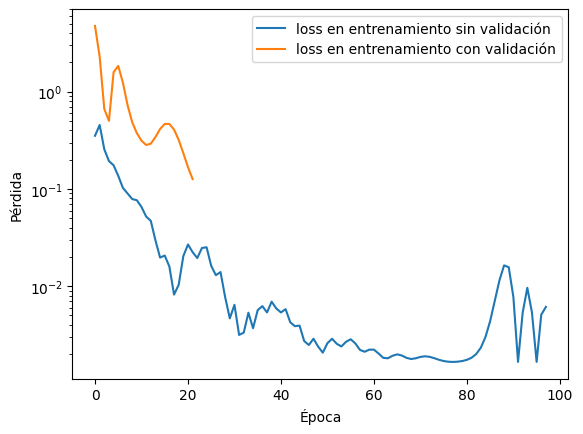

In [ ]:
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.semilogy(operador_reduc_history.history['loss'],label="loss en entrenamiento sin validación")
plt.semilogy(operador_reduc_val_history.history['loss'],label="loss en entrenamiento con validación")
plt.legend()
plt.show()

In [ ]:
s_pred =  s.eval(modelo_operador,X_test_reduc_u_list+[X_test[1]])

#MAE = np.mean(np.abs(u_pred_Simb-u_pred_sciann))*20
MSE = np.mean((y_test[:m]-s_pred)**2)
MSE

0.51957095

In [ ]:
n = y_train_ampliado.shape[0]
m = y_train_ampliado.shape[1]
N = 40

In [ ]:

#Definición de las entradas
x = sn.Variable("x")
ux = [sn.Variable(f'ux{i}') for i in range(m)]


#Definición de subredes
subnet_branches = [sn.Functional(f'branch_out_{i}', ux, [1], activation='sigmoid') for i in range(N)]
subnet_trunk = sn.Functional("trunk_out",x ,[N], 'sigmoid')

#Construcción manual del producto cartesiano de las subredes
productos = []

for i in range(N):
  productos.append(sn.utils.mul(subnet_branches[i],subnet_trunk))

s = sn.utils.add(productos[0],productos[1])

for i in range(2,N):
  s = sn.utils.add(s,productos[i])

#Restricciones del modelo
d1 = sn.Data(s)

# Definimos el modelo
modelo_operador= sn.SciModel(inputs = ux+[x], targets=[d1], loss_func='MSE',optimizer="adam")

# Resumen del modelo
#modelo_operador.summary()

In [ ]:
start_time = time.time()
operador_ampl_val_history = modelo_operador.train(X_train_ampl_u_list+[X_train_1_ampliado],y_train_ampliado,
                                              batch_size=100,
                                               epochs=3000,learning_rate = 0.01,
                                              callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", min_delta = 0, patience=20,verbose=1)],
                                              validation_data=(X_test_ampl_u_list +[X_test_1_ampliado],y_test_ampliado))
print(f"Duración del entrenamiento: {time.time()-start_time}s. ")


Total samples: 150 
Batch size: 100 
Total batches: 2 

Epoch 1/3000
1/2 [==============>...............] - ETA: 39s - batch: 0.0000e+00 - size: 100.0000 - loss: 0.6564

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2/2 [==============================] - 59s 20s/step - batch: 0.5000 - size: 75.0000 - loss: 0.7462 - val_loss: 0.5695 - lr: 0.0100 - time: 59.2397
Epoch 2/3000
2/2 [==============================] - 35s 16s/step - batch: 0.5000 - size: 75.0000 - loss: 0.7195 - val_loss: 0.4583 - lr: 0.0100 - time: 35.2630
Epoch 3/3000
2/2 [==============================] - 36s 16s/step - batch: 0.5000 - size: 75.0000 - loss: 0.3000 - val_loss: 0.2081 - lr: 0.0100 - time: 36.4058
Epoch 4/3000
2/2 [==============================] - 37s 17s/step - batch: 0.5000 - size: 75.0000 - loss: 0.4092 - val_loss: 0.2062 - lr: 0.0100 - time: 37.0199
Epoch 5/3000
2/2 [==============================] - 38s 17s/step - batch: 0.5000 - size: 75.0000 - loss: 0.3620 - val_loss: 0.2158 - lr: 0.0100 - time: 37.5375
Epoch 6/3000
2/2 [==============================] - 38s 17s/step - batch: 0.5000 - size: 75.0000 - loss: 0.2510 - val_loss: 0.2147 - lr: 0.0100 - time: 38.1274
Epoch 7/3000
2/2 [==============================] - 3

In [ ]:
start_time = time.time()
operador_ampl_history = modelo_operador.train(X_train_ampl_u_list+[X_train_1_ampliado],y_train_ampliado,
                                              batch_size=100,
                                              epochs=3000,learning_rate = 0.01,
                                              callbacks=[keras.callbacks.EarlyStopping(monitor="loss", min_delta = 0, patience=20,verbose=1)])
print(f"Duración del entrenamiento: {time.time()-start_time}s. ")

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 122/3000
2/2 [==============================] - 0s 25ms/step - batch: 0.5000 - size: 75.0000 - loss: 0.0759 - lr: 0.0100 - time: 0.1012
Epoch 123/3000
2/2 [==============================] - 0s 20ms/step - batch: 0.5000 - size: 75.0000 - loss: 0.0738 - lr: 0.0100 - time: 0.0934
Epoch 124/3000
2/2 [==============================] - 0s 22ms/step - batch: 0.5000 - size: 75.0000 - loss: 0.0706 - lr: 0.0100 - time: 0.1026
Epoch 125/3000
2/2 [==============================] - 0s 23ms/step - batch: 0.5000 - size: 75.0000 - loss: 0.0774 - lr: 0.0100 - time: 0.0997
Epoch 126/3000
2/2 [==============================] - 0s 20ms/step - batch: 0.5000 - size: 75.0000 - loss: 0.0762 - lr: 0.0100 - time: 0.0957
Epoch 127/3000
2/2 [==============================] - 0s 24ms/step - batch: 0.5000 - size: 75.0000 - loss: 0.0753 - lr: 0.0100 - time: 0.1085
Epoch 128/3000
2/2 [==============================] - 0s 21ms/step - batch: 0.5000 - si

In [ ]:
s_pred_aumentado =  s.eval(modelo_operador,X_test_ampl_u_list+[X_test_1_ampliado])

#MAE = np.mean(np.abs(u_pred_Simb-u_pred_sciann))*20
MSE = np.mean((y_test_ampliado[:m]-s_pred_aumentado)**2)
MSE

0.42278135

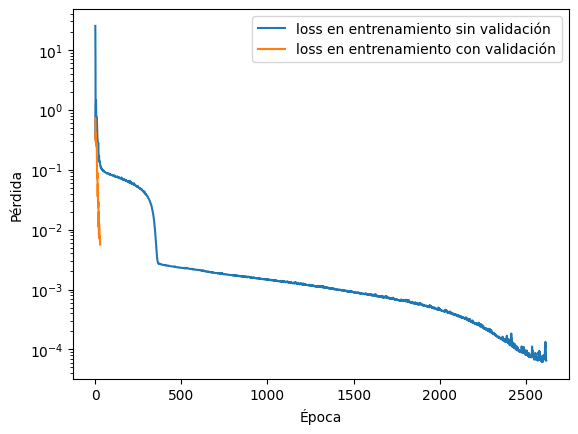

In [ ]:

plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.semilogy(operador_ampl_history.history['loss'],label="loss en entrenamiento sin validación")
plt.semilogy(operador_ampl_val_history.history['loss'],label="loss en entrenamiento con validación")
plt.legend()
plt.show()

In [ ]:
n = y_train.shape[0]
m = y_train.shape[1]
N=20

In [ ]:
#Definición de las entradas
x = sn.Variable("x")
ux = [sn.Variable(f'ux{i}') for i in range(m)]


#Definición de subredes

subnet_branches = [sn.Functional(f'branch_out_{i}', ux, [1], activation='sigmoid',kernel_initializer='glorot_uniform',bias_initializer='zeros') for i in range(N)]
subnet_trunk = sn.Functional("trunk_out",x ,[N], 'sigmoid',kernel_initializer='glorot_uniform',bias_initializer='zeros')

#Construcción manual del producto cartesiano de las subredes
productos = []

for i in range(N):
  productos.append(sn.utils.mul(subnet_branches[i],subnet_trunk))

s = sn.utils.add(productos[0],productos[1])

for i in range(2,N):
  s = sn.utils.add(s,productos[i])

#Restricciones del modelo
d1 = sn.Data(s)

# Definimos el modelo
modelo_operador_sweep_m100= sn.SciModel(inputs = ux+[x], targets=[d1], loss_func='MSE',optimizer="adadelta")

# Resumen del modelo
#modelo_operador.summary()

In [ ]:
start_time = time.time()
operador_reduc_sweep_m100_history = modelo_operador_sweep_m100.train(
                           X_train_reduc_u_list+[X_train[1]],y_train,
                           batch_size=32,
                           epochs=3000,
                           learning_rate=0.08843,
                           callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", min_delta = 0, patience=20,verbose=1)],
                           validation_data=(X_test_reduc_u_list + [X_test[1]], y_test))
train_time = time.time() - start_time


Total samples: 100 
Batch size: 32 
Total batches: 4 

Epoch 1/3000
1/4 [======>.......................] - ETA: 5s - batch: 0.0000e+00 - size: 32.0000 - loss: 0.3783

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


4/4 [==============================] - 2s 89ms/step - batch: 1.5000 - size: 25.0000 - loss: 0.4137 - val_loss: 0.2602 - lr: 0.0884 - time: 2.2185
Epoch 2/3000
4/4 [==============================] - 1s 94ms/step - batch: 1.5000 - size: 25.0000 - loss: 0.4198 - val_loss: 0.2642 - lr: 0.0884 - time: 1.3731
Epoch 3/3000
4/4 [==============================] - 2s 111ms/step - batch: 1.5000 - size: 25.0000 - loss: 0.3801 - val_loss: 0.2671 - lr: 0.0884 - time: 1.5737
Epoch 4/3000
4/4 [==============================] - 2s 117ms/step - batch: 1.5000 - size: 25.0000 - loss: 0.3657 - val_loss: 0.2706 - lr: 0.0884 - time: 1.7022
Epoch 5/3000
4/4 [==============================] - 2s 127ms/step - batch: 1.5000 - size: 25.0000 - loss: 0.3465 - val_loss: 0.2745 - lr: 0.0884 - time: 1.7811
Epoch 6/3000
4/4 [==============================] - 2s 219ms/step - batch: 1.5000 - size: 25.0000 - loss: 0.3909 - val_loss: 0.2781 - lr: 0.0884 - time: 2.1293
Epoch 7/3000
4/4 [==============================] - 2s 

In [ ]:
print(f"Duración del entrenamiento: {train_time}s. ")

Duración del entrenamiento: 55.61074948310852s. 


In [ ]:
start_time = time.time()
operador_reduc_sweep_m100_history_loss = modelo_operador_sweep_m100.train(
                           X_train_reduc_u_list+[X_train[1]],y_train,
                           batch_size=32,
                           epochs=3000,
                           learning_rate=0.08843,
                           callbacks=[keras.callbacks.EarlyStopping(monitor="loss", min_delta = 0, patience=20,verbose=1)])
train_time = time.time() - start_time


Total samples: 100 
Batch size: 32 
Total batches: 4 

Epoch 1/3000
4/4 [==============================] - 0s 7ms/step - batch: 1.5000 - size: 25.0000 - loss: 0.1266 - lr: 0.0884 - time: 0.0319
Epoch 2/3000
4/4 [==============================] - 0s 7ms/step - batch: 1.5000 - size: 25.0000 - loss: 0.1824 - lr: 0.0884 - time: 0.1008
Epoch 3/3000
4/4 [==============================] - 0s 8ms/step - batch: 1.5000 - size: 25.0000 - loss: 0.1312 - lr: 0.0884 - time: 0.1039
Epoch 4/3000
4/4 [==============================] - 0s 8ms/step - batch: 1.5000 - size: 25.0000 - loss: 0.1095 - lr: 0.0884 - time: 0.1009
Epoch 5/3000
4/4 [==============================] - 0s 7ms/step - batch: 1.5000 - size: 25.0000 - loss: 0.1327 - lr: 0.0884 - time: 0.0960
Epoch 6/3000
4/4 [==============================] - 0s 8ms/step - batch: 1.5000 - size: 25.0000 - loss: 0.0966 - lr: 0.0884 - time: 0.1007
Epoch 7/3000
4/4 [==============================] - 0s 7ms/step - batch: 1.5000 - size: 25.0000 - loss: 0.1108

In [ ]:
print(f"Duración del entrenamiento: {train_time}s. ")

Duración del entrenamiento: 48.47573232650757s. 


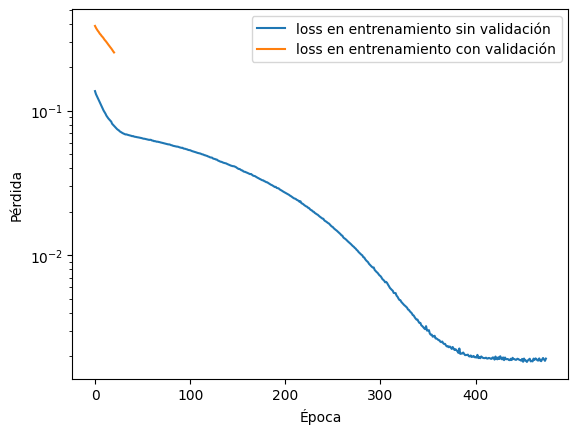

In [ ]:
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.semilogy(operador_reduc_sweep_m100_history_loss.history['loss'],label="loss en entrenamiento sin validación")
plt.semilogy(operador_reduc_sweep_m100_history.history['loss'],label="loss en entrenamiento con validación")
plt.legend()
plt.show()

In [ ]:
s_pred =  s.eval(modelo_operador_sweep_m100,X_test_reduc_u_list+[X_test[1]])

#MAE = np.mean(np.abs(u_pred_Simb-u_pred_sciann))*20
MSE = np.mean((y_test[:m]-s_pred)**2)
MSE

0.55489904

In [ ]:
n = y_train.shape[0]
m = y_train.shape[1]
N=20

In [ ]:
#Definición de las entradas
x = sn.Variable("x")
ux = [sn.Variable(f'ux{i}') for i in range(m)]


#Definición de subredes

subnet_branches = [sn.Functional(f'branch_out_{i}', ux, [1], activation='sigmoid',kernel_initializer='glorot_uniform',bias_initializer='zeros') for i in range(N)]
subnet_trunk = sn.Functional("trunk_out",x ,[N], 'elu',kernel_initializer='glorot_uniform',bias_initializer='zeros')

#Construcción manual del producto cartesiano de las subredes
productos = []

for i in range(N):
  productos.append(sn.utils.mul(subnet_branches[i],subnet_trunk))

s = sn.utils.add(productos[0],productos[1])

for i in range(2,N):
  s = sn.utils.add(s,productos[i])

#Restricciones del modelo
d1 = sn.Data(s)

# Definimos el modelo
modelo_operador_sweep_m150= sn.SciModel(inputs = ux+[x], targets=[d1], loss_func='MSE',optimizer="adam")

# Resumen del modelo
#modelo_operador.summary()

In [ ]:
start_time = time.time()
operador_reduc_sweep_m150_history = modelo_operador_sweep_m150.train(
                           X_train_reduc_u_list+[X_train[1]],y_train,
                           batch_size=48,
                           epochs=3000,
                           learning_rate=0.01845,
                           callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", min_delta = 0, patience=20,verbose=1)],
                           validation_data=(X_test_reduc_u_list + [X_test[1]], y_test))
train_time = time.time() - start_time


Total samples: 100 
Batch size: 48 
Total batches: 3 

Epoch 1/3000
3/3 [==============================] - 36s 6s/step - batch: 1.0000 - size: 33.3333 - loss: 0.3845 - val_loss: 0.2912 - lr: 0.0184 - time: 35.8359
Epoch 2/3000
3/3 [==============================] - 21s 5s/step - batch: 1.0000 - size: 33.3333 - loss: 0.2195 - val_loss: 0.5430 - lr: 0.0184 - time: 21.4314
Epoch 3/3000
3/3 [==============================] - 22s 5s/step - batch: 1.0000 - size: 33.3333 - loss: 0.1501 - val_loss: 0.2957 - lr: 0.0184 - time: 21.9876
Epoch 4/3000
3/3 [==============================] - 23s 5s/step - batch: 1.0000 - size: 33.3333 - loss: 0.1060 - val_loss: 0.5897 - lr: 0.0184 - time: 22.5033
Epoch 5/3000
3/3 [==============================] - 22s 5s/step - batch: 1.0000 - size: 33.3333 - loss: 0.0413 - val_loss: 0.4794 - lr: 0.0184 - time: 22.2499
Epoch 6/3000
3/3 [==============================] - 23s 5s/step - batch: 1.0000 - size: 33.3333 - loss: 0.0291 - val_loss: 0.6335 - lr: 0.0184 - time

In [ ]:
print(f"Duración del entrenamiento: {train_time}s. ")

Duración del entrenamiento: 534.2736785411835s. 


In [ ]:
start_time = time.time()
operador_reduc_sweep_m150_history_loss = modelo_operador_sweep_m150.train(
                           X_train_reduc_u_list+[X_train[1]],y_train,
                           batch_size=48,
                           epochs=3000,
                           learning_rate=0.01845,
                           callbacks=[keras.callbacks.EarlyStopping(monitor="loss", min_delta = 0, patience=100,verbose=1)])
train_time = time.time() - start_time


Total samples: 100 
Batch size: 48 
Total batches: 3 

Epoch 1/3000
3/3 [==============================] - 30s 1s/step - batch: 1.0000 - size: 33.3333 - loss: 0.8871 - lr: 0.0184 - time: 30.3421
Epoch 2/3000
3/3 [==============================] - 0s 10ms/step - batch: 1.0000 - size: 33.3333 - loss: 0.4765 - lr: 0.0184 - time: 0.0318
Epoch 3/3000
3/3 [==============================] - 0s 9ms/step - batch: 1.0000 - size: 33.3333 - loss: 0.2332 - lr: 0.0184 - time: 0.1045
Epoch 4/3000
3/3 [==============================] - 0s 9ms/step - batch: 1.0000 - size: 33.3333 - loss: 0.1224 - lr: 0.0184 - time: 0.0990
Epoch 5/3000
3/3 [==============================] - 0s 10ms/step - batch: 1.0000 - size: 33.3333 - loss: 0.0459 - lr: 0.0184 - time: 0.1020
Epoch 6/3000
3/3 [==============================] - 0s 9ms/step - batch: 1.0000 - size: 33.3333 - loss: 0.0440 - lr: 0.0184 - time: 0.0991
Epoch 7/3000
3/3 [==============================] - 0s 8ms/step - batch: 1.0000 - size: 33.3333 - loss: 0.0

In [ ]:
print(f"Duración del entrenamiento: {train_time}s. ")

Duración del entrenamiento: 118.21326661109924s. 


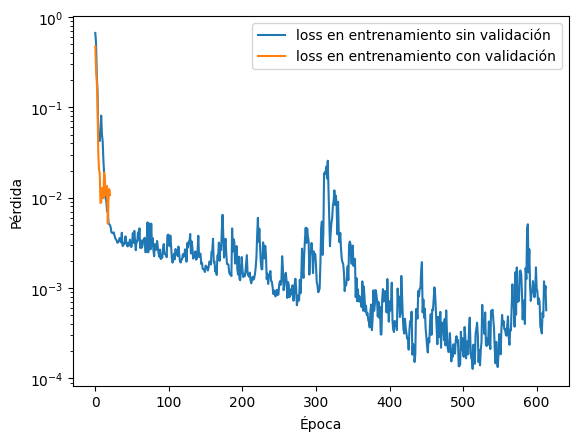

In [ ]:
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.semilogy(operador_reduc_sweep_m150_history_loss.history['loss'],label="loss en entrenamiento sin validación")
plt.semilogy(operador_reduc_sweep_m150_history.history['loss'],label="loss en entrenamiento con validación")
plt.legend()
plt.show()

In [ ]:
s_pred =  s.eval(modelo_operador_sweep_m100,X_test_reduc_u_list+[X_test[1]])

#MAE = np.mean(np.abs(u_pred_Simb-u_pred_sciann))*20
MSE = np.mean((y_test[:m]-s_pred)**2)
MSE

0.55489904